# Setup

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import plotly.express as px
import emlearn
from joblib import dump, load
from pathlib import Path
from lisa.trace import Trace

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

pl.enable_string_cache()

In [2]:
TRAINING_PATH = Path("../training")
TESTING_PATH = Path("../testing")
MODEL_PATH = Path("../models")

ANA = 'analysis'

GB6 = TRAINING_PATH   / 'geekbench_teo_deltatrace_3_1703'
GB6_2 = TRAINING_PATH / 'geekbench_teo_deltatrace_3_1803'
JET = TRAINING_PATH   / 'jetnews_teo_deltatrace_10_1703'
JET_2 = TRAINING_PATH / 'jetnews_teo_deltatrace_10_1803'
SPE = TRAINING_PATH   / 'speedometer_teo_deltatrace_10_1703'

GB6_T = TESTING_PATH / 'geekbench_teo_deltatrace_val_3_1803'
JET_T = TESTING_PATH / 'jetnews_teo_deltatrace_val_10_1803'
SPE_T = TESTING_PATH / 'speedometer_teo_deltatrace_val_10_1803'
DRA_T = TESTING_PATH / 'drarm_teo_deltatrace_10_1803'

GB6_M = TESTING_PATH / 'geekbench_menu_idle_3_1412'
JET_M = TESTING_PATH / 'jetnews_menu_idle_10_1412'
SPE_M = TESTING_PATH / 'speedometer_menu_idle_10_1412'
DRA_M = TESTING_PATH / 'drarm_menu_idle_10_1512'

WORKLOADS = [GB6, JET, SPE]

# CPUIdle baseline accuracy

In [3]:
def workload_idle_baseline_accuracy(path):
    print('Baseline for', path)
    cpu_idle = pl.read_parquet(path / ANA / 'cpu_idle.pqt')
    wakeups = cpu_idle.filter(pl.col('state') == -1)
    cpu_idle_miss = pl.read_parquet(path / ANA / 'cpu_idle_miss.pqt')
    
    print('accuracy', 1 - cpu_idle_miss.height / wakeups.height)
    print('misses', cpu_idle_miss.height / wakeups.height)
    print('too deep', cpu_idle_miss.filter(pl.col('state') == 1).height / wakeups.height, 'too shallow', cpu_idle_miss.filter(pl.col('state') == 0).height / wakeups.height)
    print()

    return (wakeups.height, cpu_idle_miss.height)

print('*** Menu idle accuracy ***\n')
wakeups_gb6_m, misses_gb6_m = workload_idle_baseline_accuracy(GB6_M)
wakeups_jet_m, misses_jet_m = workload_idle_baseline_accuracy(JET_M)
wakeups_spe_m, misses_spe_m = workload_idle_baseline_accuracy(SPE_M)
wakeups_dra_m, misses_dra_m = workload_idle_baseline_accuracy(DRA_M)

wakeups_total_m = wakeups_gb6_m + wakeups_jet_m + wakeups_spe_m + wakeups_dra_m
misses_total_m = misses_gb6_m + misses_jet_m + misses_spe_m + misses_dra_m

print('Total menu baseline')
print('accuracy', 1 - misses_total_m / wakeups_total_m)
print('misses',  misses_total_m / wakeups_total_m)
print()

print('*** TEO idle accuracy ***')

wakeups_gb6, misses_gb6 = workload_idle_baseline_accuracy(GB6)
wakeups_gb6_2, misses_gb6_2 = workload_idle_baseline_accuracy(GB6_2)
wakeups_jet, misses_jet = workload_idle_baseline_accuracy(JET)
wakeups_jet_2, misses_jet_2 = workload_idle_baseline_accuracy(JET_2)
wakeups_spe, misses_spe = workload_idle_baseline_accuracy(SPE)
wakeups_dra, misses_dra = workload_idle_baseline_accuracy(DRA_T)

wakeups_total_tr = wakeups_gb6 + wakeups_gb6_2 + wakeups_jet + wakeups_jet_2 + wakeups_spe
misses_total_tr = misses_gb6 + misses_gb6_2 + misses_jet + misses_jet_2 + misses_spe

print('Total TEO training baseline')
print('accuracy', 1 - misses_total_tr / wakeups_total_tr)
print('misses',  misses_total_tr / wakeups_total_tr)

wakeups_total = wakeups_total_tr + wakeups_dra
misses_total = misses_total_tr + misses_dra

print()

print('Total TEO baseline')
print('accuracy', 1 - misses_total / wakeups_total)
print('misses',  misses_total / wakeups_total)

*** Menu idle accuracy ***

Baseline for ../testing/geekbench_menu_idle_3_1412
accuracy 0.816481372881879
misses 0.18351862711812092
too deep 0.1578486990339208 too shallow 0.02566992808420013

Baseline for ../testing/jetnews_menu_idle_10_1412
accuracy 0.6962507146510999
misses 0.30374928534890017
too deep 0.2697473562088553 too shallow 0.03400192914004487

Baseline for ../testing/speedometer_menu_idle_10_1412
accuracy 0.7800750738896148
misses 0.21992492611038514
too deep 0.18292211339068337 too shallow 0.037002812719701766

Baseline for ../testing/drarm_menu_idle_10_1512
accuracy 0.8691868299015306
misses 0.1308131700984694
too deep 0.11541427240054901 too shallow 0.015398897697920407

Total menu baseline
accuracy 0.8250149988085469
misses 0.17498500119145316

*** TEO idle accuracy ***
Baseline for ../training/geekbench_teo_deltatrace_3_1703
accuracy 0.781614066324243
misses 0.21838593367575693
too deep 0.07305927801201954 too shallow 0.14532665566373737

Baseline for ../training/gee

# Training data

In [4]:
SLEEP_COUNT = 3_000_003

idle_data_gb6 = pl.concat([
    pl.read_parquet(GB6 / ANA / 'idle_decisions.pqt'),
    pl.read_parquet(GB6_2 / ANA / 'idle_decisions.pqt')
])
print('gb6', idle_data_gb6.shape)

idle_data_jet = pl.concat([
  pl.read_parquet(JET / ANA / 'idle_decisions.pqt'),
  pl.read_parquet(JET_2 / ANA / 'idle_decisions.pqt')
])
print('jet', idle_data_jet.shape)

idle_data_spe = pl.read_parquet(SPE / ANA / 'idle_decisions.pqt')
print('spe', idle_data_spe.shape)

idle_data = pl.concat([idle_data_gb6[:SLEEP_COUNT], idle_data_jet[:SLEEP_COUNT], idle_data_spe[:SLEEP_COUNT]])
print('total', idle_data.shape)
idle_data.head()

gb6 (3377638, 23)
jet (5287418, 23)
spe (3825222, 23)
total (9000009, 23)


sleep_id,cpu,sleep_length,time_span,measured,util,max_cap,s0hit,s0int,s0rec,s1hit,rq_cpu_time,ttwu_count,sched_count,yld_count,timer_state,duration_state,state,hit,goal_state,iteration,kernel,wa_path
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i32,str,str
60944,3,14861178,302572,271066,6,160,1257,1092,1,5853,470744,1,2,0,1,0,0,0,0,1,"""6.3.0-mainline…","""geekbench_teo_…"
60945,3,14490857,27588,386,7,160,1100,1980,1,5122,57373,0,4,0,1,0,0,0,0,1,"""6.3.0-mainline…","""geekbench_teo_…"
60946,3,14058403,420044,387765,7,160,963,2757,2,4482,392415,2,2,0,1,0,0,0,0,1,"""6.3.0-mainline…","""geekbench_teo_…"
60947,3,13575289,126749,101469,7,160,843,3437,3,3922,56885,1,2,0,1,0,0,0,0,1,"""6.3.0-mainline…","""geekbench_teo_…"
60948,3,13401298,141114,115711,7,160,738,4032,4,3432,40893,1,2,0,1,0,0,0,0,1,"""6.3.0-mainline…","""geekbench_teo_…"


Variants:
* 6f -> sleep_length, util, s1hit, s0int, yld_count, sched_count
* 7f -> sleep_length, util, max_cap s1hit, s0int, yld_count, sched_count
* 9f -> sleep_length, util, max_cap, s0hit, s0int, s0rec, s1hit, rq_cpu_time, ttwu_count

Importances  
s1hit           0.056520  
sleep_length    0.037802  
s0int           0.016370  
util            0.007691  
ttwu_count      0.003558  
rq_cpu_time     0.003029  
max_cap         0.002124  
sched_count     0.001877  
s0hit           0.000708  
yld_count       0.000357  

In [5]:
def training_strip(df):
    df = df.drop([
        'sleep_id', 'time_span', 'measured', 'state', 'hit', 'timer_state', 'duration_state', 'cpu', 'iteration', 'kernel', 'wa_path',
        's0rec', 's1rec', 'yld_count', 's0hit', 'sched_count'
    ]).to_pandas()
    X = df.drop(['goal_state'], axis=1)
    y = df['goal_state']
    return (X, y)

print('TEO decision accuracy', 1 - idle_data.filter(pl.col('state') != pl.col('goal_state')).height / idle_data.height)
X, y = training_strip(idle_data)
# Convert feature columns to int32
X = X.astype({col:'uint32' for col in X.columns})
print(X.shape, y.shape)
display(X.head(10))
y.head(10)

TEO decision accuracy 0.7949319828457949
(9000009, 7) (9000009,)


,sleep_length,util,max_cap,s0int,s1hit,rq_cpu_time,ttwu_count
0,14861178,6,160,1092,5853,470744,1
1,14490857,7,160,1980,5122,57373,0
2,14058403,7,160,2757,4482,392415,2
3,13575289,7,160,3437,3922,56885,1
4,13401298,7,160,4032,3432,40893,1
5,13224459,7,160,4552,3003,30965,0
6,2891614,6,160,3983,3652,261637,0
7,16551607,6,160,3486,4220,0,1
8,10863985,5,160,3051,4717,648275,2
9,9510917,5,160,3694,4128,258952,2


0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    1
8    0
9    0
Name: goal_state, dtype: int32

# RandomForest

## Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
base_forest = RandomForestClassifier(n_estimators=5, n_jobs=8, max_depth=8)
base_forest.fit(X_train, y_train)
print("RandomForest accuracy on full set: {:.3f}".format(base_forest.score(X, y)))
print("RandomForest accuracy on training set: {:.3f}".format(base_forest.score(X_train, y_train)))
print("RandomForest accuracy on test set: {:.3f}".format(base_forest.score(X_test, y_test)))

RandomForest accuracy on full set: 0.809
RandomForest accuracy on training set: 0.809
RandomForest accuracy on test set: 0.809


## Grid Search CV

In [173]:
parameters = {'n_estimators': [5, 6, 7], 'max_depth': [8, 9, 10], 'criterion': ('gini', 'entropy', 'log_loss')}
clf = GridSearchCV(RandomForestClassifier(n_jobs=8), parameters)
clf.fit(X_train, y_train)
print(clf.cv_results_['mean_test_score'].mean(), clf.cv_results_['mean_test_score'])
print('Best RandomForest accuracy on full dataset', clf.best_estimator_.score(X, y))
print('Best RandomForest accuracy on test dataset', clf.best_estimator_.score(X_test, y_test))

0.8092571790860735 [0.80795676 0.80904269 0.80907158 0.80943484 0.8097261  0.80973958
 0.81117335 0.81093024 0.81058165 0.80741484 0.80775424 0.80789573
 0.8091821  0.80912832 0.80962002 0.81028224 0.8101618  0.8104658
 0.80762476 0.80772758 0.80798313 0.80884106 0.80875854 0.80905661
 0.81017824 0.80998254 0.8102295 ]
Best RandomForest accuracy on full dataset 0.8113351886648114
Best RandomForest accuracy on test dataset 0.8108122522503304


In [34]:
forest = clf.best_estimator_
forest

RandomForestClassifier(max_depth=8, n_estimators=5, n_jobs=8)

In [35]:
# print(clf.cv_results_['mean_test_score'].mean(), clf.cv_results_['mean_test_score'])

print('Base RandomForest accuracy on full dataset: ', base_forest.score(X, y))
print('Base RandomForest accuracy on test dataset: ', base_forest.score(X_test, y_test))

print('RandomForest accuracy on full dataset: ', forest.score(X, y))
print('RandomForest accuracy on test dataset: ', forest.score(X_test, y_test))

Base RandomForest accuracy on full dataset:  0.8086489691288087
Base RandomForest accuracy on test dataset:  0.8089984768909197
RandomForest accuracy on full dataset:  0.8086489691288087
RandomForest accuracy on test dataset:  0.8089984768909197


In [37]:
# dump(forest, MODEL_PATH / 'final_7f_5e_8d_809.joblib')

# dump(base_forest, MODEL_PATH / 'rq_gb6_jet_spe_3m_forest_5e_10d_806.joblib')
# forest = load(Path(MODEL_PATH) / 'rq_gb6_jet_spe_3m_forest_5e_10d_808.joblib')

# dump(clf.best_estimator_, Path(MODEL_PATH) / 'gb6_3_forest_80.joblib')
# forest2 = load(Path(MODEL_PATH) / 'gb6_3_forest_80.joblib')

# dump(clf, Path(MODEL_PATH) / 'gb6_3_gridcv_80.joblib')
# clf2 = load(Path(MODEL_PATH) / 'gb6_3_gridcv_80.joblib')

# forest = load(Path(MODEL_PATH) / 'final_7f_5e_10d_811.joblib')
# forest

## Permutation Importance

In [145]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    base_forest, X_train, y_train, n_repeats=10, n_jobs=4
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

forest_importances

sleep_length    0.037802
util            0.007691
max_cap         0.002124
s0hit           0.000708
s0int           0.016370
s1hit           0.056520
rq_cpu_time     0.003029
ttwu_count      0.003558
sched_count     0.001877
yld_count       0.000357
dtype: float64

## Dump for C inference

In [7]:
X_test.to_csv('features.csv', index=False, header=False)

In [8]:
y_test.to_csv('labels.csv', index=False, header=False)

In [191]:
cmodel = emlearn.convert(forest, method='inline', dtype='int64_t')
cmodel.save(file='final_7f_5e_8d.h', name='random_forest_idle')
cmodel

In file included from tmp/myinlinetree.c:2:
tmp/myinlinetree.h:1224:9: warning: initialization discards ‘const’ qualifier from pointer target type [-Wdiscarded-qualifiers]
 1224 |         myinlinetree_leaves,
      |         ^~~~~~~~~~~~~~~~~~~
tmp/myinlinetree.c: In function ‘classify’:
tmp/myinlinetree.c:6:64: warning: passing argument 1 of ‘myinlinetree_predict’ from incompatible pointer type [-Wincompatible-pointer-types]
    6 |             printf("%d,%f\n", row, (float)myinlinetree_predict(values, length));
      |                                                                ^~~~~~
      |                                                                |
      |                                                                const float *
tmp/myinlinetree.h:6063:45: note: expected ‘const int64_t *’ {aka ‘const long int *’} but argument is of type ‘const float *’
 6063 | int32_t myinlinetree_predict(const int64_t *features, int32_t features_length) {
      |                       

# Validation

## Load validation data

In [27]:
test_data_gb6 = pl.read_parquet(GB6_T / ANA / 'idle_decisions.pqt')
print('gb6', test_data_gb6.shape)

test_data_jet = pl.read_parquet(JET_T / ANA / 'idle_decisions.pqt')
print('jet', test_data_jet.shape)

test_data_spe = pl.read_parquet(SPE_T / ANA / 'idle_decisions.pqt')
print('spe', test_data_spe.shape)

test_data_dra = pl.read_parquet(DRA_T / ANA / 'idle_decisions.pqt')
print('dra', test_data_dra.shape)

gb6 (1627098, 23)
jet (6570098, 23)
spe (4293457, 23)
dra (13390326, 23)


## GB6 validation

In [38]:
gb6_test_hits = test_data_gb6.filter(pl.col('state') == pl.col('goal_state')).height / test_data_gb6.height
gb6_test_too_deep = test_data_gb6.filter(pl.col('state') > pl.col('goal_state')).height / test_data_gb6.height
gb6_test_too_shallow = test_data_gb6.filter(pl.col('state') < pl.col('goal_state')).height / test_data_gb6.height
print('TEO GB6 test set decision accuracy', gb6_test_hits, gb6_test_too_deep, gb6_test_too_shallow)

X_test_gb6, y_test_gb6 = training_strip(test_data_gb6)
print('RandomForests GB6 test set decision accuracy', forest.score(X_test_gb6, y_test_gb6))
# print('MLP GB6 test set decision accuracy', mlp.score(X_test_gb6, y_test_gb6))

TEO GB6 test set decision accuracy 0.7841973870043476 0.07577724267376643 0.14002537032188597
RandomForests GB6 test set decision accuracy 0.8109689766688915


/home/kajetan/tools/lisa/.lisa-venv-3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


MLP GB6 test set decision accuracy 0.4812863146534505


## JetNews validation

In [42]:
jet_test_hits = test_data_jet.filter(pl.col('state') == pl.col('goal_state')).height / test_data_jet.height
jet_test_too_deep = test_data_jet.filter(pl.col('state') > pl.col('goal_state')).height / test_data_jet.height
jet_test_too_shallow = test_data_jet.filter(pl.col('state') < pl.col('goal_state')).height / test_data_jet.height
print('TEO JetNews test set decision accuracy', jet_test_hits, jet_test_too_deep, jet_test_too_shallow)

X_test_jet, y_test_jet = training_strip(test_data_jet)
print('RandomForests JetNews test set decision accuracy', forest.score(X_test_jet, y_test_jet))
# print('MLP JetNews test set decision accuracy', mlp.score(X_test_jet, y_test_jet))

TEO JetNews test set decision accuracy 0.9038658175266183 0.008279328557960626 0.08785485391542106
RandomForests JetNews test set decision accuracy 0.9032066188358225


## Speedometer validation

In [40]:
spe_test_hits = test_data_spe.filter(pl.col('state') == pl.col('goal_state')).height / test_data_spe.height
spe_test_too_deep = test_data_spe.filter(pl.col('state') > pl.col('goal_state')).height / test_data_spe.height
spe_test_too_shallow = test_data_spe.filter(pl.col('state') < pl.col('goal_state')).height / test_data_spe.height
print('TEO Speedometer test set decision accuracy', spe_test_hits, spe_test_too_deep, spe_test_too_shallow)

X_test_spe, y_test_spe = training_strip(test_data_spe)
print('RandomForests Speedometer test set decision accuracy', forest.score(X_test_spe, y_test_spe))
# print('MLP Speedometer test set decision accuracy', mlp.score(X_test_spe, y_test_spe))

TEO Speedometer test set decision accuracy 0.8508903198518117 0.008203179861822302 0.14090650028636598
RandomForests Speedometer test set decision accuracy 0.8522400480545165


## DrArm validation

In [41]:
dra_test_hits = test_data_dra.filter(pl.col('state') == pl.col('goal_state')).height / test_data_dra.height
dra_test_too_deep = test_data_dra.filter(pl.col('state') > pl.col('goal_state')).height / test_data_dra.height
dra_test_too_shallow = test_data_dra.filter(pl.col('state') < pl.col('goal_state')).height / test_data_dra.height
print('TEO DrArm test set decision accuracy', dra_test_hits, dra_test_too_deep, dra_test_too_shallow)

X_dra, y_dra = training_strip(test_data_dra)
print('RandomForests DrArm decision accuracy', forest.score(X_dra, y_dra))
# print('MLP DrArm decision accuracy', mlp.score(X_dra, y_dra))

TEO DrArm test set decision accuracy 0.9518459072617053 0.0009025919159847191 0.047251500822310076
RandomForests DrArm decision accuracy 0.9514400918991816


# MLP

In [9]:
X_mlp, y_mlp = training_strip(idle_data)
X_mlp_train, X_mlp_test, y_mlp_train, y_mlp_test = train_test_split(X_mlp, y_mlp)

scaler = StandardScaler()  
scaler.fit(X_mlp_train)  
X_mlp_train = scaler.transform(X_mlp_train)  
X_mlp_test = scaler.transform(X_mlp_test)  

mlp = MLPClassifier(solver='lbfgs')
mlp.fit(X_mlp_train, y_mlp_train)
print("MLP accuracy on training set: {:.3f}".format(mlp.score(X_mlp_train, y_mlp_train)))
print("MLP accuracy on test set: {:.3f}".format(mlp.score(X_mlp_test, y_mlp_test)))

/home/kajetan/tools/lisa/.lisa-venv-3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP accuracy on training set: 0.808
MLP accuracy on test set: 0.808


In [10]:
dump(mlp, MODEL_PATH / 'final_lbfgs_mlp_808.joblib')

print('MLP accuracy on test dataset: ', mlp.score(X_mlp_test, y_mlp_test))

MLP accuracy on test dataset:  0.8080709225721032


# Optimal Idle Residency Simulations

In [78]:
def cpu_cluster(cpu):
    return 'little' if cpu < 4 else 'big' if cpu > 5 else 'mid'

cluster_ids = {'little':0, 'mid':1, 'big':2}

def simulate_goal_idle_residency(data):
    measured_state = data.filter(pl.col('measured') != -1).group_by(['cpu', 'state']).agg(pl.col('measured').sum() / (10**9)).sort(['cpu', 'state']).rename({'measured':'residency'}).with_columns(pl.col('state').cast(pl.Int32))
    measured_goal_state = data.filter(pl.col('measured') != -1).group_by(['cpu', 'goal_state']).agg(pl.col('measured').sum() / (10**9)).sort(['cpu', 'goal_state']).rename({'goal_state':'state'}).rename({'measured':'optimal_residency'})
    result = measured_state.join(measured_goal_state, on=['cpu', 'state'])

    result = result.with_columns(
        pl.col("cpu").map_elements(cpu_cluster).alias('cluster'),
        pl.col("cpu").map_elements(lambda c: cluster_ids[cpu_cluster(c)]).alias('cluster_id')
    ).group_by(['cluster', 'cluster_id', 'state']).sum().sort(['cluster_id', 'state']).drop(['cpu', 'cluster_id'])
    
    return result

sim_res = simulate_goal_idle_residency(idle_data).melt(id_vars=['cluster', 'state'], value_vars=['residency', 'optimal_residency']).with_columns(
    pl.col('value') / pl.col('value').sum()
)

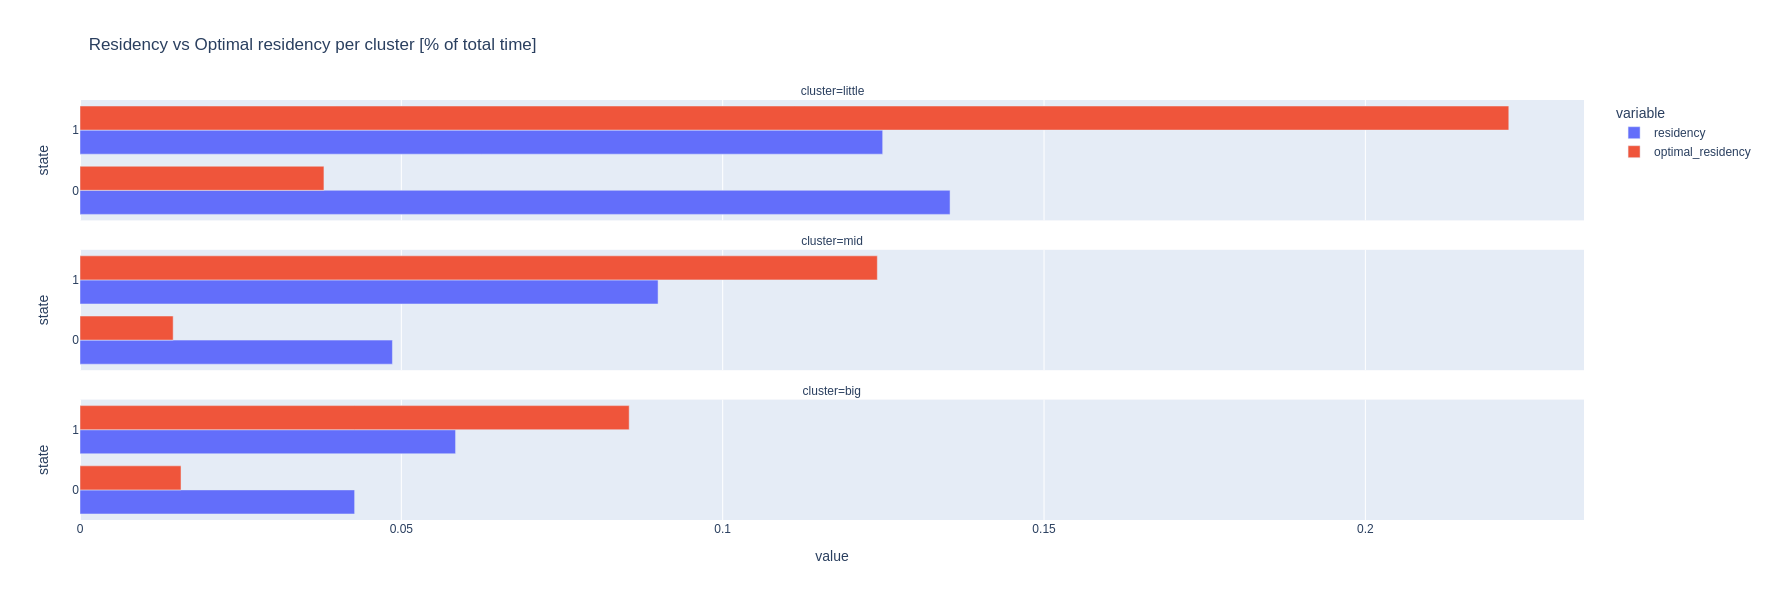

In [80]:
px.bar(sim_res, x='value', y='state', color='variable', facet_col='cluster', facet_col_wrap=1, barmode='group', height=600, width=500, orientation='h', title='Residency vs Optimal residency per cluster [% of total time]')